In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tag import tnt
from tqdm import tqdm

In [8]:
index_dict = {"happy": 0, "sad": 1}
NUM_TAGS = len(index_dict)
TIME_STEPS = 3

# Initialize π and back pointer matrices
transition = np.array([[0.7, 0.3], [0.5, 0.5]])

In [9]:
transition

array([[0.7, 0.3],
       [0.5, 0.5]])

In [10]:
emission = {
    "happy": {"red": 0.8, "green": 0.1, "blue": 0.1},
    "sad": {"red": 0.2, "green": 0.3, "blue": 0.5},
}

In [11]:
# NOTE: observed is G, B, R
observed = ["green", "blue", "red"]

cur_sequece = []
res = {}
def dfs(cur_day, cur_score):
    if cur_day >= len(observed):
        res["".join(cur_sequece)] = cur_score
        return
    cur_observation = observed[cur_day]
    for mood in ["happy", "sad"]:
        cur_score += emission[mood][cur_observation]
        # at the start, there is no previous mood
        if cur_sequece:
            cur_score += transition[index_dict[mood]][index_dict[cur_sequece[-1]]]
        cur_sequece.append(mood)
        dfs(cur_day + 1, cur_score)
        cur_sequece.pop()
dfs(0, 0)
res

{'happyhappyhappy': 2.4,
 'happyhappysad': 3.1,
 'happysadhappy': 3.0,
 'happysadsad': 3.7,
 'sadhappyhappy': 2.3,
 'sadhappysad': 3.0,
 'sadsadhappy': 2.9,
 'sadsadsad': 3.6}

implementing https://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/hmms.pdf and https://aclanthology.org/A00-1031.pdf

heavily relied on https://github.com/stathwang/POS-Taggers and nltk/tag/tnt.py

In [4]:
X = pd.read_csv("data/train_x.csv", na_filter=False)
Y = pd.read_csv("data/train_y.csv")
word_with_tag = X.merge(Y, on="id")
print(f"the shape is {word_with_tag.shape}")
word_with_tag.head()

the shape is (696475, 3)


,id,word,tag
0,0,-DOCSTART-,O
1,1,Pierre,NNP
2,2,Vinken,NNP
3,3,",",","
4,4,61,CD


In [5]:
tag_word_tupl = list(word_with_tag[["tag", "word"]].itertuples(index=False, name=None))
word_tag_tupl = list(word_with_tag[["word", "tag"]].itertuples(index=False, name=None))
word_tag_tupl[:5]

[('-DOCSTART-', 'O'),
 ('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD')]

A bit of data visualization

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696475 entries, 0 to 696474
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      696475 non-null  int64 
 1   word    696475 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.6+ MB


In [7]:
print(f"there are {X['word'].nunique()} unique words")
print("*" in list(X["word"].unique()))

there are 37505 unique words
False


In [8]:
word_count_df = X.groupby(by="word", as_index=False).count().sort_values(
    by="id", ascending=False
).rename(columns={"id": "count"}).reset_index(drop=True)
print(word_count_df["count"].sum())
word_count_df

696475


,word,count
0,",",35472
1,the,30079
2,.,28510
3,of,16761
4,to,16130
...,...,...
37500,amps,1
37501,amply,1
37502,amplify,1
37503,amplifiers,1


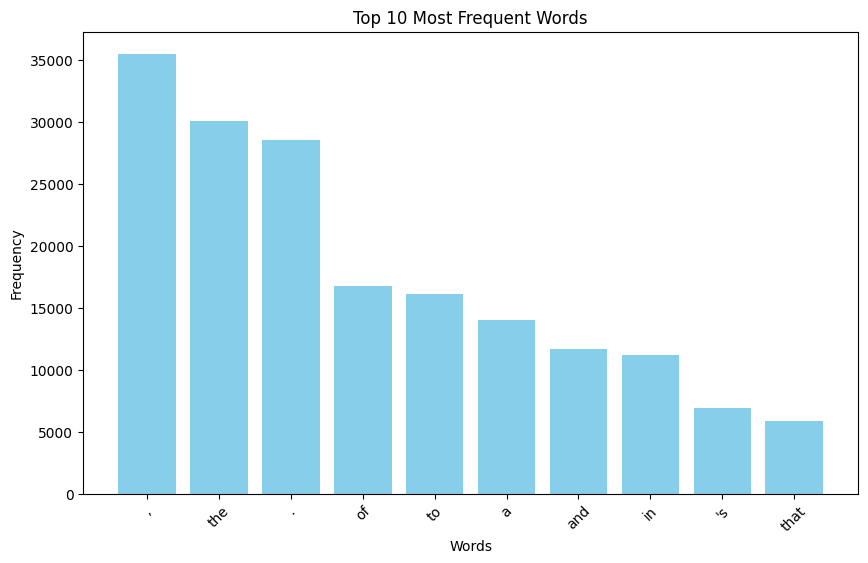

In [9]:
top_10_words = word_count_df.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_10_words["word"], top_10_words["count"], color="skyblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

In [10]:
penn_treebank_tags = [
    "CC",   # Coordinating conjunction
    "CD",   # Cardinal number
    "DT",   # Determiner
    "EX",   # Existential there
    "FW",   # Foreign word
    "IN",   # Preposition or subordinating conjunction
    "JJ",   # Adjective
    "JJR",  # Adjective, comparative
    "JJS",  # Adjective, superlative
    "LS",   # List item marker
    "MD",   # Modal
    "NN",   # Noun, singular or mass
    "NNS",  # Noun, plural
    "NNP",  # Proper noun, singular
    "NNPS", # Proper noun, plural
    "PDT",  # Predeterminer
    "POS",  # Possessive ending
    "PRP",  # Personal pronoun
    "PRP$", # Possessive pronoun
    "RB",   # Adverb
    "RBR",  # Adverb, comparative
    "RBS",  # Adverb, superlative
    "RP",   # Particle
    "SYM",  # Symbol
    "TO",   # to
    "UH",   # Interjection
    "VB",   # Verb, base form
    "VBD",  # Verb, past tense
    "VBG",  # Verb, gerund or present participle
    "VBN",  # Verb, past participle
    "VBP",  # Verb, non-3rd person singular present
    "VBZ",  # Verb, 3rd person singular present
    "WDT",  # Wh-determiner
    "WP",   # Wh-pronoun
    "WP$",  # Possessive wh-pronoun
    "WRB"   # Wh-adverb
]
outlier_tags = [item for item in list(Y['tag'].unique()) if item not in penn_treebank_tags]

In [11]:
grouped = word_with_tag.groupby(by=["tag"]).apply(lambda x: x["word"].value_counts())
grouped

tag  word    
#    #             91
$    $           4976
     C$            54
     US$           51
     A$            35
                 ... 
WRB  WHY            2
     wherever       1
``   ``          5148
     `             80
     non-``         1
Name: count, Length: 43418, dtype: int64

In [13]:
tag_totals = word_with_tag["tag"].value_counts()
tag_totals[:5]

tag
NN     96805
IN     72097
NNP    67431
DT     59928
JJ     45356
Name: count, dtype: int64

In [14]:
normalized = grouped.groupby(level=0).apply(lambda x: x / tag_totals[x.name]).reset_index(level=0, drop=True)
# print out words for tags that do not appear in 
for weird_tag in outlier_tags:
  print(f"Normalized data for tag: {weird_tag}")
  print(normalized.loc[weird_tag].to_dict())

normalized.head()

Normalized data for tag: O
{'-DOCSTART-': 1.0}
Normalized data for tag: ,
{',': 0.9999154334038055, 'Wa': 2.8188865398167723e-05, 'an': 2.8188865398167723e-05, '2': 2.8188865398167723e-05}
Normalized data for tag: .
{'.': 0.9886604015674307, '?': 0.009605714880188647, '!': 0.001733883552380622}
Normalized data for tag: ``
{'``': 0.9845094664371773, '`': 0.015299292407726142, 'non-``': 0.00019124115509657678}
Normalized data for tag: ''
{"''": 0.9817825661116553, "'": 0.01821743388834476}
Normalized data for tag: :
{'--': 0.4314269850083287, ':': 0.2670738478622987, ';': 0.24736257634647418, '...': 0.04053303720155469, '-': 0.013603553581343698}
Normalized data for tag: $
{'$': 0.9709268292682927, 'C$': 0.01053658536585366, 'US$': 0.009951219512195122, 'A$': 0.006829268292682927, 'HK$': 0.0013658536585365853, 'NZ$': 0.0001951219512195122, 'C': 0.0001951219512195122}
Normalized data for tag: (
{'(': 0.8452497551420176, '{': 0.15475024485798236}
Normalized data for tag: )
{')': 0.84466019

tag  word
#    #       1.000000
$    $       0.970927
     C$      0.010537
     US$     0.009951
     A$      0.006829
Name: count, dtype: float64

### Construct sentences from X_train ###

In [15]:
# word_tag_tupl is a list of list of tuples.
# NOTE: remove the rows containg the tag: O
word_tag_tupl = [item for item in word_tag_tupl if item[0] != "-DOCSTART-"]
word_tag_tupl = tnt.basic_sent_chop(word_tag_tupl, raw=False)

In [38]:
word_tag_tupl[1:2]

[[('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')]]

### Emission probabilities ###
This shows that the emission_matrix, or B probabilities, is very sparse

In [17]:
emission_mx = normalized.unstack(level=1).fillna(0)
emission_mx.head()

word,!,#,$,%,&,','','30s,'40s,'50s,...,zlotys,zombies,zone,zones,zoning,zoo,zoology,zoomed,{,}
tag,,,,,,,,,,,,,,,,,,,,,
#,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
$,0.0,0.0,0.970927,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
'',0.0,0.0,0.000000,0.0,0.0,0.018217,0.981783,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
(,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15475,0.00000
),0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.15534


In [18]:
emission_probs = emission_mx.to_dict()

In [37]:
emission_probs['buy']['VB']

0.01524311476256911

In [46]:
hi = word_with_tag.groupby(by="word")['tag'].unique()
word_tag_dict = {k: list(v) for k, v in hi.to_dict().items()}

In [48]:
word_tag_dict['work']

['NN', 'VB', 'VBP']

### Transition probabilities ###

In [20]:
def process_ngrams(sentences):
    # Initialize counters
    unigram_counts = defaultdict(int)
    bigram_counts = defaultdict(int)
    trigram_counts = defaultdict(int)

    # Process the sentences
    for sentence in sentences:
        tags = [tag for _, tag in sentence]

        # Add start and end tags
        padded_tags = ["START", "START"] + tags + ["END"]

        # Count unigrams
        for tag in padded_tags:
            unigram_counts[tag] += 1

        # Count bigrams
        for bigram in zip(padded_tags, padded_tags[1:]):
            bigram_counts[bigram] += 1

        # Count trigrams
        for trigram in zip(padded_tags, padded_tags[1:], padded_tags[2:]):
            trigram_counts[trigram] += 1

    return unigram_counts, bigram_counts, trigram_counts


In [21]:
# Calculate probabilities: q(s|u, v) = c(u, v, s) / c(u, v)
def calculate_probabilities(unigram_counts, bigram_counts, trigram_counts):
    bigram_probabilities = {}
    trigram_probabilities = {}

    # Calculate bigram probabilities
    for (t1, t2), count in bigram_counts.items():
        bigram_probabilities[(t1, t2)] = count / unigram_counts[t1]

    # Calculate trigram probabilities
    for (t1, t2, t3), count in trigram_counts.items():
        trigram_probabilities[(t1, t2, t3)] = count / bigram_counts[(t1, t2)]

    return bigram_probabilities, trigram_probabilities

unigram_counts, bigram_counts, trigram_counts = process_ngrams(word_tag_tupl)
bigram_probabilities, trigram_probabilities = calculate_probabilities(
    unigram_counts, bigram_counts, trigram_counts
)

In [32]:
def deleted_interpolation(trigram_counts, bigram_counts, unigram_counts):
    lambda1 = lambda2 = lambda3 = 0
    
    N = max(unigram_counts.values())

    for (t1, t2, t3), count in trigram_counts.items():
        if count > 0:
            case1 = (count - 1) / (bigram_counts[(t1, t2)] - 1) if bigram_counts[(t1, t2)] > 1 else 0
            case2 = (bigram_counts[(t2, t3)] - 1) / (unigram_counts[t2] - 1) if unigram_counts[t2] > 1 else 0
            case3 = (unigram_counts[t3] - 1) / (N - 1) if N > 1 else 0

            max_case = max(case1, case2, case3)

            if max_case == case1:
                lambda3 += count
            elif max_case == case2:
                lambda2 += count
            else:
                lambda1 += count

    total = lambda1 + lambda2 + lambda3
    lambda1 /= total
    lambda2 /= total
    lambda3 /= total

    return lambda1, lambda2, lambda3

In [52]:
lambda1, lambda2, lambda3 = deleted_interpolation(
    trigram_counts, bigram_counts, unigram_counts
)
print(f"l1: {lambda1}, l2: {lambda2}, l3: {lambda3}")

l1: 0.8484580585005352, l2: 0.01709707497323618, l3: 0.13444486652622856


In [73]:
from itertools import islice


print("First 5 Bigram Probabilities:")
for (t1, t2), prob in islice(bigram_probabilities.items(), 5):
    print(f"P({t2}|{t1}) = {prob:.4f}")

print("\nFirst 5 Trigram Probabilities:")
for (t1, t2, t3), prob in islice(trigram_probabilities.items(), 5):
    print(f"P({t3}|{t1}, {t2}) = {prob:.4f}")

First 5 Bigram Probabilities:
P(START|START) = 0.5000
P(NNP|START) = 0.0927
P(NNP|NNP) = 0.3772
P(,|NNP) = 0.1381
P(CD|,) = 0.0217

First 5 Trigram Probabilities:
P(NNP|START, START) = 0.1855
P(NNP|START, NNP) = 0.5954
P(,|NNP, NNP) = 0.2014
P(CD|NNP, ,) = 0.0260
P(NNS|,, CD) = 0.1699


### Viterbi ###

In [136]:
import numpy as np

PTB_TAGS = list(Y["tag"].unique())
PTB_TAGS.append("START")
PTB_TAGS.append("END")
PTB_TAGS.append("UNK")
print(PTB_TAGS)

NUM_TAGS = len(PTB_TAGS)
TAG_TO_IDX = {tag: idx for idx, tag in enumerate(PTB_TAGS)}


def viterbi(
    sentence,
    unigram_counts,
    bigram_probabilities,
    trigram_probabilities,
    emission_probs,
    lambda1,
    lambda2,
    lambda3,
):
    T = len(sentence)
    # Initialize trellis and backpointers
    trellis = np.full((NUM_TAGS, NUM_TAGS, T + 1), -np.inf)
    backpointers = np.zeros((NUM_TAGS, NUM_TAGS, T + 1), dtype=int)

    # Initialization: Set π(0, START, START) = 0 (in log space)
    start_idx = TAG_TO_IDX["START"]
    trellis[start_idx, start_idx, 0] = 0

    # Fill in the rest of the trellis
    for t in range(1, T + 1):
        word = sentence[t - 1]
        #print(f"current word is {word}")
        is_unknown = word not in emission_probs
        if is_unknown:
            print(f"Word '{word}' not found in training corpus. Treating as UNK.")
            emission_probs[word] = {tag: 1e-10 for tag in PTB_TAGS}

        for u in range(NUM_TAGS):
            for v in range(NUM_TAGS):
                if is_unknown:
                    # Copy over previous time step's values for UNK tag cells
                    if PTB_TAGS[v] == 'UNK':
                        max_log_prob = trellis[u, TAG_TO_IDX['UNK'], t - 1]
                        max_w = TAG_TO_IDX['UNK']
                    else:
                        max_log_prob = -np.inf
                        max_w = -1
                else:
                    max_log_prob = -np.inf
                    max_w = -1
                    for w in range(NUM_TAGS):
                        trans_prob = (
                            lambda1 * trigram_probabilities.get((PTB_TAGS[w], PTB_TAGS[u], PTB_TAGS[v]), 1e-10)
                            + lambda2 * bigram_probabilities.get((PTB_TAGS[u], PTB_TAGS[v]), 1e-10)
                            + lambda3 * unigram_counts.get((PTB_TAGS[v]), 1e-10)
                        )
                        emis_prob = emission_probs[word].get(PTB_TAGS[v], 1e-10)
                        log_prob = (
                            trellis[w, u, t - 1]
                            + np.log(trans_prob)
                            + np.log(emis_prob)
                        )
                        if log_prob > max_log_prob:
                            max_log_prob = log_prob
                            max_w = w
                trellis[u, v, t] = max_log_prob
                backpointers[u, v, t] = max_w

    # Find the best path
    best_path = []
    max_log_prob = -np.inf
    max_u, max_v = -1, -1
    for u in range(NUM_TAGS):
        for v in range(NUM_TAGS):
            log_prob = trellis[u, v, T] + np.log(
                trigram_probabilities.get((PTB_TAGS[u], PTB_TAGS[v], "END"), 1e-10)
            )
            if log_prob > max_log_prob:
                max_log_prob = log_prob
                max_u, max_v = u, v

    # Backtrack to find the best path
    best_path.append(PTB_TAGS[max_v])
    best_path.append(PTB_TAGS[max_u])
    for t in range(T, 1, -1):
        max_w = backpointers[max_u, max_v, t]
        best_path.append(PTB_TAGS[max_w])
        max_u, max_v = max_w, max_u

    # Reverse the best path to get it in the correct order
    best_path = list(reversed(best_path))
    return best_path

['O', 'NNP', ',', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', '.', 'VBZ', 'VBG', 'CC', 'VBD', 'VBN', 'RB', 'TO', 'PRP', 'RBR', 'WDT', 'VBP', 'RP', 'PRP$', 'JJS', 'POS', '``', 'EX', "''", 'WP', ':', 'JJR', 'WRB', '$', 'NNPS', 'WP$', '(', ')', 'PDT', 'RBS', 'FW', 'UH', 'SYM', 'LS', '#', 'START', 'END', 'UNK']


### Testing ###

In [133]:
X_DEV = pd.read_csv("data/dev_x.csv", na_filter=False)
Y_DEV = pd.read_csv("data/dev_y.csv")
X_DEV.head()

,id,word
0,0,-DOCSTART-
1,1,Following
2,2,is
3,3,a
4,4,weekly


In [134]:
merged_dev = X_DEV.merge(Y_DEV, on="id")[['word', 'tag']]
merged_dev_no_docstart = merged_dev[merged_dev["tag"] != "O"]
data = tnt.basic_sent_chop(
    list(merged_dev_no_docstart[["word", "tag"]].itertuples(index=False, name=None)), raw=False
)
x_test = []
y_test = []

for sublist in data:
    tokens = []
    tags = []
    for token, tag in sublist:
        tokens.append(token)
        tags.append(tag)
    x_test.append(tokens)
    y_test.append(tags)
print(x_test[:5])
print(y_test[:5])

[['Following', 'is', 'a', 'weekly', 'listing', 'of', 'unadited', 'net', 'asset', 'values', 'of', 'publicly', 'traded', 'investment', 'fund', 'shares', ',', 'reported', 'by', 'the', 'companies', 'as', 'of', 'Friday', "'s", 'close', '.'], ['Also', 'shown', 'is', 'the', 'closing', 'listed', 'market', 'price', 'or', 'a', 'dealer-to-dealer', 'asked', 'price', 'of', 'each', 'fund', "'s", 'shares', ',', 'with', 'the', 'percentage', 'of', 'difference', '.'], ['Closed', 'End', 'Bond', 'Funds', 'Flexible', 'Portfolio', 'Funds', 'Specialized', 'Equity', 'and', 'Convertible', 'Funds', 'a', '-', 'Ex-dividend', '.'], ['b', '-', 'As', 'of', 'Thursday', "'s", 'close', '.'], ['c', '-', 'Translated', 'at', 'Commercial', 'Rand', 'exchange', 'rate', '.']]
[['VBG', 'VBZ', 'DT', 'JJ', 'NN', 'IN', 'JJ', 'JJ', 'NN', 'NNS', 'IN', 'RB', 'JJ', 'NN', 'NN', 'NNS', ',', 'VBN', 'IN', 'DT', 'NNS', 'IN', 'IN', 'NNP', 'POS', 'NN', '.'], ['RB', 'VBN', 'VBZ', 'DT', 'NN', 'JJ', 'NN', 'NN', 'CC', 'DT', 'JJ', 'JJ', 'NN', 'I

### Metric ###

In [131]:
def compute_accuracy(predicted_tags, expected_tags):
    correct = sum(p == e for p, e in zip(predicted_tags, expected_tags))
    total = len(expected_tags)
    accuracy = correct / total
    return accuracy

sentence = "abc def I love you"
my_lst = sentence.split(" ")
predicted = viterbi(
    my_lst,
    unigram_counts,
    bigram_probabilities,
    trigram_probabilities,
    emission_probs,
    lambda1,
    lambda2,
    lambda3,
)
predicted

current word is abc
current word is def
current word is I


/var/folders/qh/rrvm0zvs2jg1wtj1pwtyd71m0000gn/T/ipykernel_22543/435535241.py:64: RuntimeWarning: divide by zero encountered in log
  + np.log(emis_prob)


current word is love
current word is you


['START', 'NN', 'NN', 'PRP', 'NN', 'PRP']

In [137]:
def compute_overall_accuracy(
    x_test,
    y_test,
    start=0,
    end=None,
):
    if end is None:
        end = len(x_test)

    total_correct = 0
    total_tags = 0

    for i in tqdm(range(start, end), desc="Processing sentences"):
        predicted = viterbi(
            x_test[i],
            unigram_counts,
            bigram_probabilities,
            trigram_probabilities,
            emission_probs,
            lambda1,
            lambda2,
            lambda3,
        )
        expected = y_test[i]
        total_correct += sum(p == e for p, e in zip(predicted[1:], expected))
        total_tags += len(expected)

    overall_accuracy = total_correct / total_tags if total_tags > 0 else 0
    return overall_accuracy


overall_accuracy = compute_overall_accuracy(
    x_test,
    y_test,
    start=197, end=323
)
print(f"Overall Accuracy is {overall_accuracy}")

Processing sentences:   0%|          | 0/126 [00:00<?, ?it/s]/var/folders/qh/rrvm0zvs2jg1wtj1pwtyd71m0000gn/T/ipykernel_22543/3653745714.py:64: RuntimeWarning: divide by zero encountered in log
  + np.log(emis_prob)
Processing sentences:  11%|█         | 14/126 [01:35<16:53,  9.05s/it]

### NLTK ###

In [15]:
import nltk
nltk.download('treebank')
nltk.download("brown")

[nltk_data] Downloading package treebank to /Users/tindo/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /Users/tindo/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
from nltk.tag import PerceptronTagger
from nltk.corpus import treebank
from nltk.corpus import brown
tagger = PerceptronTagger()
gold_data = treebank.tagged_sents()[10:20]
print(tagger.accuracy(gold_data))

0.8859315589353612


In [18]:
wsj = nltk.corpus.treebank.tagged_words()
cfd1 = nltk.ConditionalFreqDist(wsj)
cfd2 = nltk.ConditionalFreqDist(tag_word_tupl)
cfd2

<ConditionalFreqDist with 46 conditions>

In [19]:
cfd2["VB"]

FreqDist({'be': 2703, 'have': 786, 'make': 382, 'buy': 295, 'sell': 284, 'get': 279, 'take': 263, 'do': 232, 'pay': 198, 'yield': 171, ...})

In [33]:
cfd2["VB"].freq("buy")

0.01524311476256911

In [ ]:
trigram_counter = dict(nltk.FreqDist(nltk.trigrams(list(X["word"].values))))
bigram_counter = dict(nltk.FreqDist(nltk.bigrams(list(X["word"].values))))
transition_probs = {key: val / bigram_counter[key[:2]] for key, val in trigram_counter.items()}
transition_probs

In [40]:
from nltk.corpus import brown

brown_tagged_sents = brown.tagged_sents(categories="news")
size = int(len(brown_tagged_sents) * 0.9)
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
bigram_tagger = nltk.TrigramTagger(train_sents)
bigram_tagger.evaluate(test_sents)
train_sents

/var/folders/qh/rrvm0zvs2jg1wtj1pwtyd71m0000gn/T/ipykernel_98796/267290831.py:8: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  bigram_tagger.evaluate(test_sents)


[[('The', 'AT'), ('Fulton', 'NP-TL'), ('County', 'NN-TL'), ('Grand', 'JJ-TL'), ('Jury', 'NN-TL'), ('said', 'VBD'), ('Friday', 'NR'), ('an', 'AT'), ('investigation', 'NN'), ('of', 'IN'), ("Atlanta's", 'NP$'), ('recent', 'JJ'), ('primary', 'NN'), ('election', 'NN'), ('produced', 'VBD'), ('``', '``'), ('no', 'AT'), ('evidence', 'NN'), ("''", "''"), ('that', 'CS'), ('any', 'DTI'), ('irregularities', 'NNS'), ('took', 'VBD'), ('place', 'NN'), ('.', '.')], [('The', 'AT'), ('jury', 'NN'), ('further', 'RBR'), ('said', 'VBD'), ('in', 'IN'), ('term-end', 'NN'), ('presentments', 'NNS'), ('that', 'CS'), ('the', 'AT'), ('City', 'NN-TL'), ('Executive', 'JJ-TL'), ('Committee', 'NN-TL'), (',', ','), ('which', 'WDT'), ('had', 'HVD'), ('over-all', 'JJ'), ('charge', 'NN'), ('of', 'IN'), ('the', 'AT'), ('election', 'NN'), (',', ','), ('``', '``'), ('deserves', 'VBZ'), ('the', 'AT'), ('praise', 'NN'), ('and', 'CC'), ('thanks', 'NNS'), ('of', 'IN'), ('the', 'AT'), ('City', 'NN-TL'), ('of', 'IN-TL'), ('Atlant

In [22]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t3 = nltk.TrigramTagger(train_sents, backoff=t2)
t3.evaluate(test_sents)

/var/folders/qh/rrvm0zvs2jg1wtj1pwtyd71m0000gn/T/ipykernel_98796/142853021.py:5: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  t3.evaluate(test_sents)


0.843317053722715

In [13]:
from nltk.tag import tnt 
from nltk.corpus import brown
# res = tnt.basic_sent_chop(word_tag_tupl, raw=False)
tagger = tnt.TnT()
sents = list(brown.tagged_sents(tagset="universal"))
tagger.train(sents[200:1000])
print(dict(tagger._uni))
print(dict(tagger._bi))
print(dict(tagger._tri))
print(dict(tagger._wd))
list_of_words = "the city was urged to remedy this problem".split(" ")
tagger.accuracy(sents[10:11])

{('VERB', False): 2818, ('ADJ', False): 1184, ('NOUN', False): 5216, ('.', False): 1767, ('DET', False): 2119, ('ADV', False): 512, ('ADP', False): 2244, ('PRON', False): 454, ('PRT', False): 412, ('CONJ', False): 396, ('NUM', False): 330, ('X', False): 6}
{('BOS', False): FreqDist({('DET', False): 215, ('NOUN', False): 207, ('PRON', False): 85, ('.', False): 77, ('ADP', False): 57, ('VERB', False): 42, ('ADJ', False): 33, ('ADV', False): 27, ('CONJ', False): 27, ('NUM', False): 17, ...}), ('VERB', False): FreqDist({('VERB', False): 626, ('DET', False): 485, ('ADP', False): 472, ('NOUN', False): 376, ('ADV', False): 200, ('.', False): 196, ('PRT', False): 162, ('ADJ', False): 133, ('PRON', False): 86, ('NUM', False): 33, ...}), ('ADJ', False): FreqDist({('NOUN', False): 859, ('ADP', False): 79, ('ADJ', False): 69, ('.', False): 55, ('PRT', False): 33, ('CONJ', False): 31, ('NUM', False): 19, ('VERB', False): 19, ('DET', False): 5, ('ADV', False): 5, ...}), ('.', False): FreqDist({('NOU

0.9285714285714286

In [12]:
from nltk.corpus import treebank
d = list(treebank.tagged_sents())
d[2]

[('Rudolph', 'NNP'),
 ('Agnew', 'NNP'),
 (',', ','),
 ('55', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 ('and', 'CC'),
 ('former', 'JJ'),
 ('chairman', 'NN'),
 ('of', 'IN'),
 ('Consolidated', 'NNP'),
 ('Gold', 'NNP'),
 ('Fields', 'NNP'),
 ('PLC', 'NNP'),
 (',', ','),
 ('was', 'VBD'),
 ('named', 'VBN'),
 ('*-1', '-NONE-'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('of', 'IN'),
 ('this', 'DT'),
 ('British', 'JJ'),
 ('industrial', 'JJ'),
 ('conglomerate', 'NN'),
 ('.', '.')]